<a href="https://colab.research.google.com/github/aasr-1001/Datathon/blob/main/Datathon_HousePricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!pip install xgboost lightgbm catboost optuna scikit-learn pandas numpy


In [3]:
import numpy as np
import pandas as pd
import optuna
import xgboost as xgb
from sklearn.model_selection import train_test_split



In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tabulate import tabulate


In [5]:

df = pd.read_csv("/content/drive/MyDrive/train_processed.csv")

target_column = "SalePrice"
X = df.drop(columns=[target_column])
y = df[target_column]

X.fillna(X.median(), inplace=True)

scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def optimize_rf(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10)
    }

    model = RandomForestRegressor(**params, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    rmse = mean_squared_error(y_test, y_pred) ** 0.5  # Compute RMSE manually
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(optimize_rf, n_trials=10)
print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)
best_rf = RandomForestRegressor(**study.best_params, random_state=42, n_jobs=-1)
best_rf.fit(X_train, y_train)

y_pred = best_rf.predict(X_test)

rmse = mean_squared_error(y_test, y_pred)**0.5
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = (abs(y_test - y_pred) / y_test).mean() * 100


metrics_df = pd.DataFrame({
    "Metric": ["RMSE", "MAE", "R² Score", "MAPE"],
    "Value": [rmse, mae, r2, mape]
})


print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid'))


[I 2025-04-04 05:11:01,039] A new study created in memory with name: no-name-11f63f25-86f2-4fb4-ac12-ba54d5883845
[I 2025-04-04 05:11:04,738] Trial 0 finished with value: 20296.24983171883 and parameters: {'n_estimators': 350, 'max_depth': 17, 'min_samples_split': 9, 'min_samples_leaf': 7}. Best is trial 0 with value: 20296.24983171883.
[I 2025-04-04 05:11:11,203] Trial 1 finished with value: 20888.655386727565 and parameters: {'n_estimators': 500, 'max_depth': 6, 'min_samples_split': 3, 'min_samples_leaf': 7}. Best is trial 0 with value: 20296.24983171883.
[I 2025-04-04 05:11:26,182] Trial 2 finished with value: 19885.304242641698 and parameters: {'n_estimators': 950, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 2 with value: 19885.304242641698.
[I 2025-04-04 05:11:33,607] Trial 3 finished with value: 20055.50548335749 and parameters: {'n_estimators': 750, 'max_depth': 10, 'min_samples_split': 3, 'min_samples_leaf': 6}. Best is trial 2 with value: 19

Best parameters: {'n_estimators': 950, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 2}
Best RMSE: 19885.304242641698
╒════╤══════════╤══════════════╕
│    │ Metric   │        Value │
╞════╪══════════╪══════════════╡
│  0 │ RMSE     │ 19885.3      │
├────┼──────────┼──────────────┤
│  1 │ MAE      │ 13719.1      │
├────┼──────────┼──────────────┤
│  2 │ R² Score │     0.919124 │
├────┼──────────┼──────────────┤
│  3 │ MAPE     │     9.64481  │
╘════╧══════════╧══════════════╛


In [7]:
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import optuna
import warnings
import logging

warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

df = pd.read_csv("/content/drive/MyDrive/train_processed.csv")
target_column = "SalePrice"
X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def optimize_model(trial, model_type):
    params = {}

    if model_type == "xgboost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'n_jobs': -1  # Use all CPU cores
        }
        model = xgb.XGBRegressor(**params, random_state=42)

    elif model_type == "lightgbm":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'verbose': -1,  # Suppress LightGBM warnings
            'n_jobs': -1  # Use all CPU cores
        }
        model = lgb.LGBMRegressor(**params, random_state=42)

    elif model_type == "catboost":
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        }
        model = CatBoostRegressor(**params, random_state=42, verbose=0, thread_count=-1)  # Use all CPU cores

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return mean_squared_error(y_val, y_pred) ** 0.5

model_results = {}
for model_type in ["xgboost", "lightgbm", "catboost"]:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: optimize_model(trial, model_type), n_trials=10)

    best_params = study.best_params
    print(f"Best Params for {model_type}: {best_params}")

    if model_type == "xgboost":
        final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    elif model_type == "lightgbm":
        final_model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1, n_jobs=-1)
    elif model_type == "catboost":
        final_model = CatBoostRegressor(**best_params, random_state=42, verbose=0, thread_count=-1)

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)**0.5
    mae = mean_absolute_error(y_val, y_pred)

    print(f"{model_type} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    model_results[model_type] = {"rmse": rmse, "model": final_model}

xgb_model = model_results["xgboost"]["model"]
lgb_model = model_results["lightgbm"]["model"]
cat_model = model_results["catboost"]["model"]

# Stacking Model
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)],
    final_estimator=Ridge(alpha=1.0)
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_val)
stacking_rmse = mean_squared_error(y_val, y_pred) ** 0.5
stacking_mae = mean_absolute_error(y_val, y_pred)

print(f"Stacking Model - RMSE: {stacking_rmse:.2f}, MAE: {stacking_mae:.2f}")
model_results["stacking"] = {"rmse": stacking_rmse, "model": stacking_model}
from sklearn.metrics import r2_score
from tabulate import tabulate

# Results in Tabular format
metrics_data = []

for model_name in ["xgboost", "lightgbm", "catboost", "stacking"]:
    model = model_results[model_name]["model"]
    preds = model.predict(X_val)

    rmse = mean_squared_error(y_val, preds) ** 0.5
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    mape = (abs(y_val - preds) / y_val).mean() * 100

    metrics_data.append([model_name.capitalize(), rmse, mae, r2, mape])


metrics_df = pd.DataFrame(metrics_data, columns=["Model", "RMSE", "MAE", "R² Score", "MAPE"])
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))

# Select the best model
best_model_name = min(model_results, key=lambda x: model_results[x]["rmse"])
best_model = model_results[best_model_name]["model"]

print(f"Best Model Selected: {best_model_name} with RMSE: {model_results[best_model_name]['rmse']:.2f}")


[I 2025-04-04 05:20:44,106] A new study created in memory with name: no-name-188e397c-763a-47c6-82e3-3d36c8223247
[I 2025-04-04 05:20:51,288] Trial 0 finished with value: 18688.50351667568 and parameters: {'n_estimators': 700, 'learning_rate': 0.0630047084154819, 'max_depth': 5, 'subsample': 0.7727236081726825, 'colsample_bytree': 0.9534321730851354}. Best is trial 0 with value: 18688.50351667568.
[I 2025-04-04 05:20:52,216] Trial 1 finished with value: 18573.645199533312 and parameters: {'n_estimators': 800, 'learning_rate': 0.014916032617032773, 'max_depth': 3, 'subsample': 0.877825195316182, 'colsample_bytree': 0.885499261521947}. Best is trial 1 with value: 18573.645199533312.
[I 2025-04-04 05:20:58,263] Trial 2 finished with value: 19313.810710313028 and parameters: {'n_estimators': 650, 'learning_rate': 0.08068615221217453, 'max_depth': 9, 'subsample': 0.5257434964759928, 'colsample_bytree': 0.9435019715086392}. Best is trial 1 with value: 18573.645199533312.
[I 2025-04-04 05:21:

Best Params for xgboost: {'n_estimators': 950, 'learning_rate': 0.015811422693275262, 'max_depth': 5, 'subsample': 0.7268833052026393, 'colsample_bytree': 0.6051856309351313}


[I 2025-04-04 05:21:19,815] A new study created in memory with name: no-name-c7bcd39d-7f15-4113-9e30-94a47d0a0684


xgboost - RMSE: 17803.27, MAE: 11964.60


[I 2025-04-04 05:21:20,154] Trial 0 finished with value: 19011.076361114334 and parameters: {'n_estimators': 700, 'learning_rate': 0.1643942826919754, 'max_depth': 4, 'num_leaves': 67, 'subsample': 0.992046100540869, 'colsample_bytree': 0.8518492275059124}. Best is trial 0 with value: 19011.076361114334.
[I 2025-04-04 05:21:20,397] Trial 1 finished with value: 19068.532591009876 and parameters: {'n_estimators': 250, 'learning_rate': 0.06726783920459758, 'max_depth': 8, 'num_leaves': 93, 'subsample': 0.699719655795201, 'colsample_bytree': 0.9318385252629369}. Best is trial 0 with value: 19011.076361114334.
[I 2025-04-04 05:21:20,907] Trial 2 finished with value: 18440.193509850214 and parameters: {'n_estimators': 550, 'learning_rate': 0.100624641875296, 'max_depth': 9, 'num_leaves': 47, 'subsample': 0.8296673674434718, 'colsample_bytree': 0.6072307196639424}. Best is trial 2 with value: 18440.193509850214.
[I 2025-04-04 05:21:21,369] Trial 3 finished with value: 18534.53584678047 and pa

Best Params for lightgbm: {'n_estimators': 650, 'learning_rate': 0.06193631425402203, 'max_depth': 7, 'num_leaves': 92, 'subsample': 0.5418023025030633, 'colsample_bytree': 0.6231185081837731}


[I 2025-04-04 05:21:23,821] A new study created in memory with name: no-name-ba627186-437a-42e5-a49b-d080e60b4874


lightgbm - RMSE: 18269.00, MAE: 12541.83


[I 2025-04-04 05:21:47,052] Trial 0 finished with value: 18361.17781224659 and parameters: {'iterations': 800, 'learning_rate': 0.03430387974014299, 'depth': 9, 'l2_leaf_reg': 5.713130658129878}. Best is trial 0 with value: 18361.17781224659.
[I 2025-04-04 05:21:47,679] Trial 1 finished with value: 19218.958172830862 and parameters: {'iterations': 200, 'learning_rate': 0.05158280948694942, 'depth': 5, 'l2_leaf_reg': 9.039007914018173}. Best is trial 0 with value: 18361.17781224659.
[I 2025-04-04 05:21:47,875] Trial 2 finished with value: 30976.485463604 and parameters: {'iterations': 100, 'learning_rate': 0.017341809411607227, 'depth': 3, 'l2_leaf_reg': 3.1733976667014723}. Best is trial 0 with value: 18361.17781224659.
[I 2025-04-04 05:22:24,959] Trial 3 finished with value: 20060.468726864314 and parameters: {'iterations': 750, 'learning_rate': 0.16530730001130275, 'depth': 10, 'l2_leaf_reg': 5.755049422295221}. Best is trial 0 with value: 18361.17781224659.
[I 2025-04-04 05:23:12,85

Best Params for catboost: {'iterations': 900, 'learning_rate': 0.03325836925440869, 'depth': 5, 'l2_leaf_reg': 7.356821224246946}
catboost - RMSE: 17863.11, MAE: 12398.62
Stacking Model - RMSE: 17585.33, MAE: 11886.62
╒════╤══════════╤════════════╤════════════╤════════════╤════════╕
│    │ Model    │       RMSE │        MAE │   R² Score │   MAPE │
╞════╪══════════╪════════════╪════════════╪════════════╪════════╡
│  0 │ Xgboost  │ 17803.2685 │ 11964.6010 │     0.9352 │ 8.1974 │
├────┼──────────┼────────────┼────────────┼────────────┼────────┤
│  1 │ Lightgbm │ 18269.0028 │ 12541.8267 │     0.9317 │ 8.5873 │
├────┼──────────┼────────────┼────────────┼────────────┼────────┤
│  2 │ Catboost │ 17863.1147 │ 12398.6199 │     0.9347 │ 8.3908 │
├────┼──────────┼────────────┼────────────┼────────────┼────────┤
│  3 │ Stacking │ 17585.3340 │ 11886.6229 │     0.9368 │ 8.0740 │
╘════╧══════════╧════════════╧════════════╧════════════╧════════╛
Best Model Selected: stacking with RMSE: 17585.33


In [8]:
import joblib

# Save the best model
joblib.dump(best_model, "/content/drive/MyDrive/best_model.pkl")
print(f"Best model ({best_model_name}) saved successfully.")


Best model (stacking) saved successfully.


In [9]:
loaded_model = joblib.load("/content/drive/MyDrive/best_model.pkl")



In [10]:
train_df = pd.read_csv("/content/drive/MyDrive/train_processed.csv")
test_df = pd.read_csv("/content/drive/MyDrive/test_processed.csv")

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

Train shape: (1460, 79)
Test shape: (1459, 79)


In [11]:

X_test = pd.read_csv("/content/drive/MyDrive/test_processed.csv")

missing_cols = set(X_train.columns) - set(X_test.columns)
extra_cols = set(X_test.columns) - set(X_train.columns)

print(f"Missing columns in test data: {missing_cols}")
print(f"Extra columns in test data: {extra_cols}")

for col in missing_cols:
    X_test[col] = 0

X_test = X_test[X_train.columns]


Missing columns in test data: set()
Extra columns in test data: {'SalePrice'}


In [12]:

X_test = pd.read_csv("/content/drive/MyDrive/test_processed.csv")
if "SalePrice" in X_test.columns:
    X_test = X_test.drop(columns=["SalePrice"])
test_predictions = best_model.predict(X_test)
submission_df = pd.DataFrame({"Id": X_test.index, "SalePrice": test_predictions})
submission_df.to_csv("/content/drive/MyDrive/submission.csv", index=False)

print("Submission file saved successfully!")


Submission file saved successfully!


        Feature  Importance
59   GarageArea  274.164593
74      TotalSF  222.434397
3       LotArea  198.928985
34    BsmtUnfSF  184.654423
35  TotalBsmtSF  180.004262
40     1stFlrSF  174.658829
43    GrLivArea  169.282098
77    PorchArea  123.814824
31   BsmtFinSF1  121.621330
2   LotFrontage  111.406163


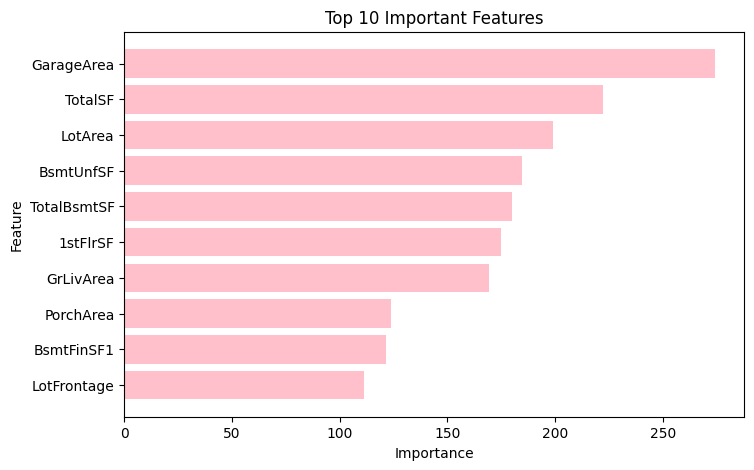

In [21]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/train_processed.csv")
feature_names = df.drop(columns=["SalePrice"]).columns.tolist()

best_model = joblib.load("/content/drive/MyDrive/best_model.pkl")

estimators = best_model.named_estimators_

feature_importance = {}

for name, model in estimators.items():
    if hasattr(model, "feature_importances_"):
        feature_importance[name] = model.feature_importances_

if feature_importance:
    avg_importance = sum(feature_importance.values()) / len(feature_importance)

    importance_df = pd.DataFrame({"Feature": feature_names, "Importance": avg_importance})
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    top_10_df = importance_df.head(10)
    print(top_10_df)

    plt.figure(figsize=(8, 5))
    plt.barh(top_10_df["Feature"], top_10_df["Importance"], color="pink")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title("Top 10 Important Features")
    plt.gca().invert_yaxis()
    plt.show()

else:
    print("No feature_importances_ found in base models.")


SHAP summary for XGBoost:


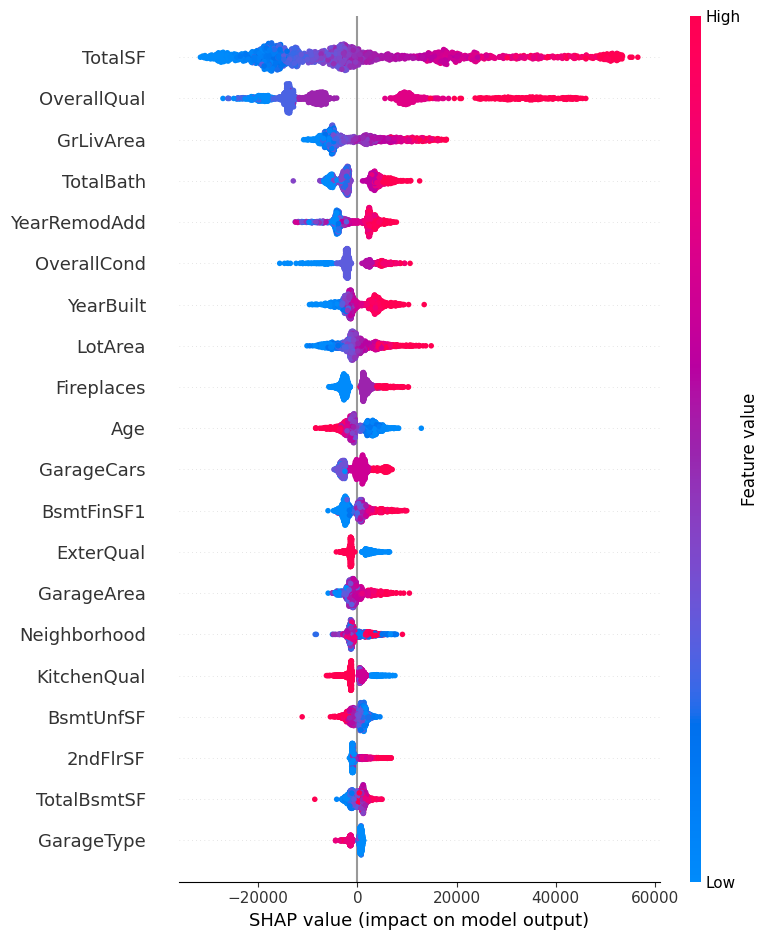

SHAP summary for LightGBM:


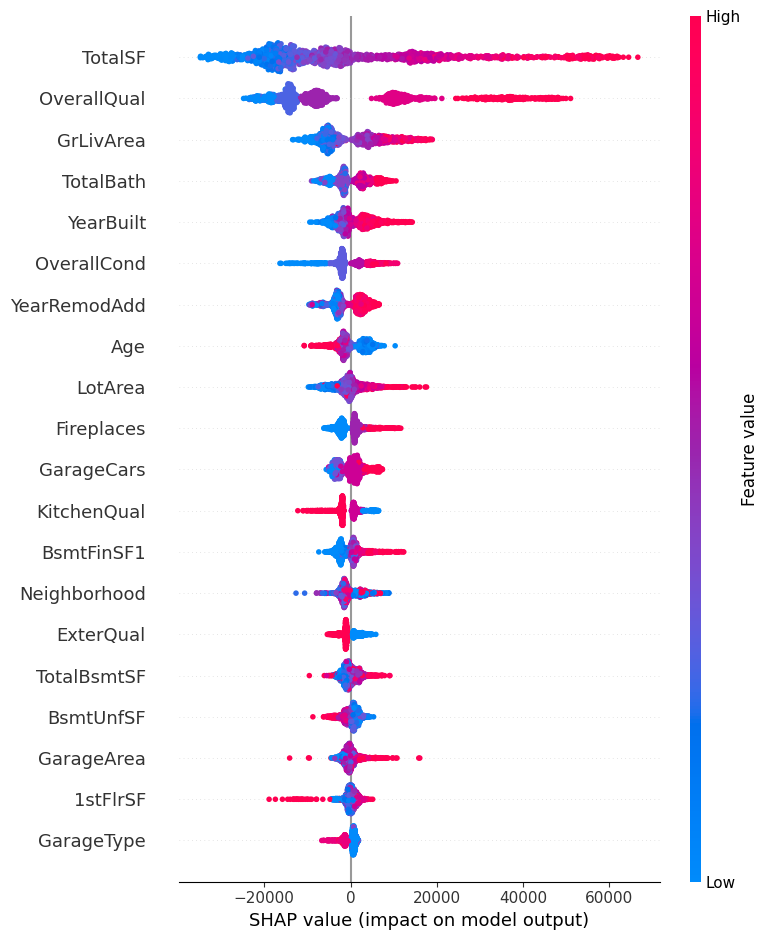

SHAP summary for CatBoost:


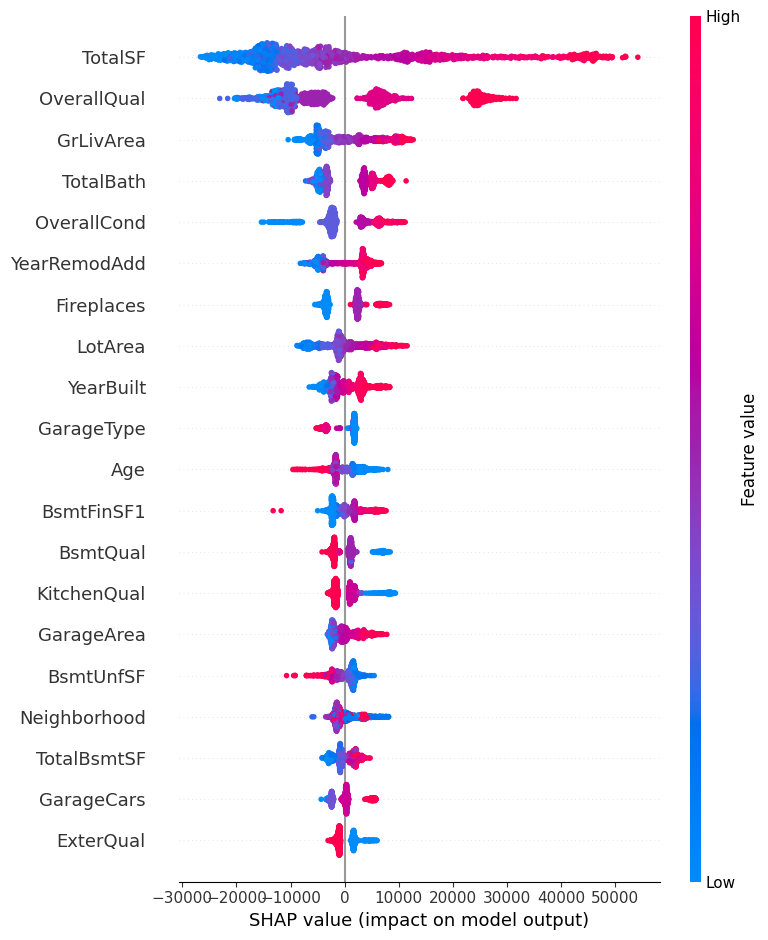

In [25]:
import shap
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("/content/drive/MyDrive/train_processed.csv")
X = df.drop(columns=["SalePrice"])
feature_names = X.columns.tolist()

xgb_model = estimators["xgb"]
lgb_model = estimators["lgb"]
cat_model = estimators["cat"]

# XGBoost SHAP
print("SHAP summary for XGBoost:")
xgb_explainer = shap.TreeExplainer(xgb_model)
xgb_shap_values = xgb_explainer.shap_values(X)
shap.summary_plot(xgb_shap_values, X, feature_names=feature_names, show=True)

# LightGBM SHAP
print("SHAP summary for LightGBM:")
lgb_explainer = shap.TreeExplainer(lgb_model)
lgb_shap_values = lgb_explainer.shap_values(X)
shap.summary_plot(lgb_shap_values, X, feature_names=feature_names, show=True)

# CatBoost SHAP
print("SHAP summary for CatBoost:")
cat_explainer = shap.TreeExplainer(cat_model)
cat_shap_values = cat_explainer.shap_values(X)
shap.summary_plot(cat_shap_values, X, feature_names=feature_names, show=True)


In [1]:
# PREV
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
import optuna
import warnings
import logging

warnings.filterwarnings("ignore", category=UserWarning)
logging.getLogger("lightgbm").setLevel(logging.CRITICAL)

df = pd.read_csv("/content/train_prev_processed.csv")
target_column = "SalePrice"
X = df.drop(columns=[target_column])
y = df[target_column]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def optimize_model(trial, model_type):
    params = {}

    if model_type == "xgboost":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'n_jobs': -1  # Use all CPU cores
        }
        model = xgb.XGBRegressor(**params, random_state=42)

    elif model_type == "lightgbm":
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'num_leaves': trial.suggest_int('num_leaves', 20, 100),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
            'verbose': -1,  # Suppress LightGBM warnings
            'n_jobs': -1  # Use all CPU cores
        }
        model = lgb.LGBMRegressor(**params, random_state=42)

    elif model_type == "catboost":
        params = {
            'iterations': trial.suggest_int('iterations', 100, 1000, step=50),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
            'depth': trial.suggest_int('depth', 3, 10),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        }
        model = CatBoostRegressor(**params, random_state=42, verbose=0, thread_count=-1)  # Use all CPU cores

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    return mean_squared_error(y_val, y_pred) ** 0.5

model_results = {}
for model_type in ["xgboost", "lightgbm", "catboost"]:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: optimize_model(trial, model_type), n_trials=10)

    best_params = study.best_params
    print(f"Best Params for {model_type}: {best_params}")

    if model_type == "xgboost":
        final_model = xgb.XGBRegressor(**best_params, random_state=42, n_jobs=-1)
    elif model_type == "lightgbm":
        final_model = lgb.LGBMRegressor(**best_params, random_state=42, verbose=-1, n_jobs=-1)
    elif model_type == "catboost":
        final_model = CatBoostRegressor(**best_params, random_state=42, verbose=0, thread_count=-1)

    final_model.fit(X_train, y_train)
    y_pred = final_model.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred)**0.5
    mae = mean_absolute_error(y_val, y_pred)

    print(f"{model_type} - RMSE: {rmse:.2f}, MAE: {mae:.2f}")
    model_results[model_type] = {"rmse": rmse, "model": final_model}

xgb_model = model_results["xgboost"]["model"]
lgb_model = model_results["lightgbm"]["model"]
cat_model = model_results["catboost"]["model"]

# Stacking Model
stacking_model = StackingRegressor(
    estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)],
    final_estimator=Ridge(alpha=1.0)
)

stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_val)
stacking_rmse = mean_squared_error(y_val, y_pred) ** 0.5
stacking_mae = mean_absolute_error(y_val, y_pred)

print(f"Stacking Model - RMSE: {stacking_rmse:.2f}, MAE: {stacking_mae:.2f}")
model_results["stacking"] = {"rmse": stacking_rmse, "model": stacking_model}
from sklearn.metrics import r2_score
from tabulate import tabulate

# Results in Tabular format
metrics_data = []

for model_name in ["xgboost", "lightgbm", "catboost", "stacking"]:
    model = model_results[model_name]["model"]
    preds = model.predict(X_val)

    rmse = mean_squared_error(y_val, preds) ** 0.5
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    mape = (abs(y_val - preds) / y_val).mean() * 100

    metrics_data.append([model_name.capitalize(), rmse, mae, r2, mape])


metrics_df = pd.DataFrame(metrics_data, columns=["Model", "RMSE", "MAE", "R² Score", "MAPE"])
print(tabulate(metrics_df, headers='keys', tablefmt='fancy_grid', floatfmt=".4f"))

# Select the best model
best_model_name = min(model_results, key=lambda x: model_results[x]["rmse"])
best_model = model_results[best_model_name]["model"]

print(f"Best Model Selected: {best_model_name} with RMSE: {model_results[best_model_name]['rmse']:.2f}")


[I 2025-04-04 11:06:15,151] A new study created in memory with name: no-name-0b99d959-8c2e-4dc0-a5cd-b596c9b6f350
[I 2025-04-04 11:06:59,184] Trial 0 finished with value: 26867.224344915125 and parameters: {'n_estimators': 850, 'learning_rate': 0.038196884293046636, 'max_depth': 10, 'subsample': 0.8627393975713816, 'colsample_bytree': 0.5269086870841413}. Best is trial 0 with value: 26867.224344915125.
[I 2025-04-04 11:07:01,792] Trial 1 finished with value: 39676.8272925142 and parameters: {'n_estimators': 100, 'learning_rate': 0.013106359322955934, 'max_depth': 6, 'subsample': 0.9849621796981488, 'colsample_bytree': 0.8417920270897333}. Best is trial 0 with value: 26867.224344915125.
[I 2025-04-04 11:07:03,351] Trial 2 finished with value: 26171.55952556133 and parameters: {'n_estimators': 150, 'learning_rate': 0.04267847869871851, 'max_depth': 8, 'subsample': 0.7479040030597992, 'colsample_bytree': 0.6378382236922291}. Best is trial 2 with value: 26171.55952556133.
[I 2025-04-04 11:

Best Params for xgboost: {'n_estimators': 1000, 'learning_rate': 0.12990976097988832, 'max_depth': 5, 'subsample': 0.7725579158693339, 'colsample_bytree': 0.5278213163376121}


[I 2025-04-04 11:07:36,435] A new study created in memory with name: no-name-b64ccbfe-3ee3-4b34-a896-37e0968a3e3c


xgboost - RMSE: 23751.82, MAE: 14216.37


[I 2025-04-04 11:07:37,465] Trial 0 finished with value: 29752.11457762564 and parameters: {'n_estimators': 850, 'learning_rate': 0.12813688669679144, 'max_depth': 9, 'num_leaves': 90, 'subsample': 0.9870483689148555, 'colsample_bytree': 0.8851425667723491}. Best is trial 0 with value: 29752.11457762564.
[I 2025-04-04 11:07:38,532] Trial 1 finished with value: 29042.77600062968 and parameters: {'n_estimators': 500, 'learning_rate': 0.020016117511343884, 'max_depth': 10, 'num_leaves': 70, 'subsample': 0.6710943099546864, 'colsample_bytree': 0.740961807681861}. Best is trial 1 with value: 29042.77600062968.
[I 2025-04-04 11:07:39,726] Trial 2 finished with value: 29899.61285905347 and parameters: {'n_estimators': 300, 'learning_rate': 0.07649574043958987, 'max_depth': 4, 'num_leaves': 75, 'subsample': 0.666491792742242, 'colsample_bytree': 0.8445940063952155}. Best is trial 1 with value: 29042.77600062968.
[I 2025-04-04 11:07:41,261] Trial 3 finished with value: 29313.391361365568 and pa

Best Params for lightgbm: {'n_estimators': 900, 'learning_rate': 0.025893063966663302, 'max_depth': 7, 'num_leaves': 54, 'subsample': 0.5330352700821177, 'colsample_bytree': 0.6016418802838395}


[I 2025-04-04 11:07:45,318] A new study created in memory with name: no-name-9c4eccef-bbed-49d6-b236-7aabc5b9262d


lightgbm - RMSE: 28740.75, MAE: 16593.04


[I 2025-04-04 11:07:57,759] Trial 0 finished with value: 27545.843649684844 and parameters: {'iterations': 1000, 'learning_rate': 0.038613874095443645, 'depth': 7, 'l2_leaf_reg': 7.805403209974215}. Best is trial 0 with value: 27545.843649684844.
[I 2025-04-04 11:08:02,060] Trial 1 finished with value: 25836.555091876875 and parameters: {'iterations': 1000, 'learning_rate': 0.08590739219737713, 'depth': 5, 'l2_leaf_reg': 7.434890095576498}. Best is trial 1 with value: 25836.555091876875.
[I 2025-04-04 11:08:12,949] Trial 2 finished with value: 28379.26489970627 and parameters: {'iterations': 850, 'learning_rate': 0.22047672595915507, 'depth': 7, 'l2_leaf_reg': 4.456707212211656}. Best is trial 1 with value: 25836.555091876875.
[I 2025-04-04 11:08:24,197] Trial 3 finished with value: 29132.91056682023 and parameters: {'iterations': 500, 'learning_rate': 0.06772365007957759, 'depth': 8, 'l2_leaf_reg': 2.1057452096583322}. Best is trial 1 with value: 25836.555091876875.
[I 2025-04-04 11:0

Best Params for catboost: {'iterations': 1000, 'learning_rate': 0.08590739219737713, 'depth': 5, 'l2_leaf_reg': 7.434890095576498}
catboost - RMSE: 25836.56, MAE: 15530.62
Stacking Model - RMSE: 24954.17, MAE: 15006.87
╒════╤══════════╤════════════╤════════════╤════════════╤════════╕
│    │ Model    │       RMSE │        MAE │   R² Score │   MAPE │
╞════╪══════════╪════════════╪════════════╪════════════╪════════╡
│  0 │ Xgboost  │ 23751.8235 │ 14216.3711 │     0.9265 │ 8.9314 │
├────┼──────────┼────────────┼────────────┼────────────┼────────┤
│  1 │ Lightgbm │ 28740.7485 │ 16593.0443 │     0.8923 │ 9.7123 │
├────┼──────────┼────────────┼────────────┼────────────┼────────┤
│  2 │ Catboost │ 25836.5551 │ 15530.6203 │     0.9130 │ 9.1704 │
├────┼──────────┼────────────┼────────────┼────────────┼────────┤
│  3 │ Stacking │ 24954.1708 │ 15006.8672 │     0.9188 │ 8.9557 │
╘════╧══════════╧════════════╧════════════╧════════════╧════════╛
Best Model Selected: xgboost with RMSE: 23751.82
